# Training: Curriculum

#### 1) Train on various close-to-terminal standard situations
#### 2) Train on self-play episodes of the champion
#### 3) Avoid frustrating the freshling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random

import numpy as np
import tensorflow as tf

from aegomoku.trainer import Trainer, create_curriculum, TERMINAL_OPPORTUNITY, TERMINAL_THREAT, ENDGAME, ALL_GAMEPLAY
from aegomoku.utils import analyse_example

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BOARD_SIZE = 19

---

# Read curriculum game data

### Pickle files
Pickle files contain only single representatives of the 8 symmetries and the board positions are represented by the list of integers for the stones instead of the canonical N x X x 3 representation

In [4]:
from pathlib import Path

DATA_DIR='workspace/Project-Ellie/DATA'
PHASE = '3.2'
HOST = os.uname()[1]
SELFPLAY_DIR = Path(Path.home()) / DATA_DIR / 'selfplay' / PHASE
print(SELFPLAY_DIR)

/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2


In [5]:
all_3_2 = list(SELFPLAY_DIR.rglob("*.pickle"))
all_3_2

[PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00003.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00009.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00006.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00002.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00001.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00007.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00011.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00012.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00004.pickle'),
 PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/selfplay/3.2/tensorbook/00005.pickle'),
 PosixPath('/home/wgiersche/wo

In [6]:
curriculum = create_curriculum(all_3_2, 512, ALL_GAMEPLAY)

Preparing course: All Gameplay


100%|██████████| 36/36 [01:29<00:00,  2.50s/it]


Prepared course: All Gameplay: 184656 examples



## Terminal Opportunities

In [7]:
curriculum

{'TERMINAL_OPPORTUNITY': {'title': 'Terminal Opportunities',
  'filter': <function aegomoku.trainer.create_curriculum.<locals>.is_opportunity(_s, _p, v)>},
 'TERMINAL_THREAT': {'title': 'Terminal Threats',
  'filter': <function aegomoku.trainer.create_curriculum.<locals>.is_threat(_s, _p, v)>},
 'ENDGAME': {'title': 'General Endgame',
  'filter': <function aegomoku.trainer.create_curriculum.<locals>.is_endgame(_s, _p, v)>},
 'ALL_GAMEPLAY': {'title': 'All Gameplay',
  'filter': None,
  'num_examples': 184656,
  'dataset': <BatchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
  'data_dir': '/tmp/tmpkyft9ncf'}}

Next to play: WHITE
Value from WHITE's point of view: -0.22884029150009155


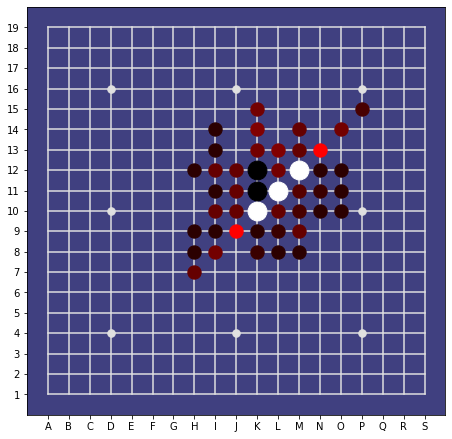

In [8]:
ds = curriculum[ALL_GAMEPLAY].get('dataset')
if ds is not None:
    s, p, v = next(iter(ds))
    example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
    analyse_example(example, disp_width=7.5, policy_cutoff=.001)
else:
    print("Course not available")

In [15]:
ds = curriculum[TERMINAL_THREAT].get('dataset')
if ds is not None:
    s, p, v = next(iter(ds))
    example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
    analyse_example(example, disp_width=7.5, policy_cutoff=.001)
else:
    print("Course not available")

Course not available


In [16]:
ds = curriculum[ENDGAME].get('dataset')
if ds is not None:
    s, p, v = next(iter(ds))
    example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
    analyse_example(example, disp_width=7.5, policy_cutoff=.001)
else:
    print("Course not available")

Course not available


## General Gameplay

Next to play: BLACK
Value from BLACK's point of view: 0.2172190099954605


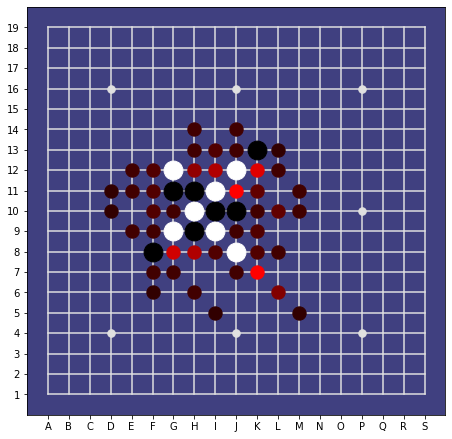

In [9]:
ds = curriculum[ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(example, disp_width=7.5, policy_cutoff=.001)


---


## Choose a model to start with


#### A freshman

In [8]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=512, num_blocks=10)
model.compile()
model.summary()

Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 21, 21, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 21, 21, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 21, 21, 512)  186368      ['inputs[0][0]']                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 21, 21, 5)    1540        ['heuristic_detector[0][0]']     
                                                                                      

#### Clone the current champion

In [10]:
model_file = Path.home() / "workspace" / "Project-Ellie" / "DATA" / 'models' / '3_c3.model'
model = tf.keras.models.load_model(model_file)

In [10]:
trainer = Trainer(model)

### You may want a warmup?

In [25]:
ds = curriculum[ENDGAME].get('dataset')
if ds is not None:
    trainer.train(ds, epochs_per_train=10, report_every=1, v_weight=1.0)
    model.save('models/from_endgame.model')
else:
    print("No warm-up today...;-)")

No warm-up today...;-)


## All game play
This will last for a couple of hours

In [9]:
ds = curriculum[ALL_GAMEPLAY]['dataset']

In [11]:
trainer.train(ds, epochs_per_train=200, report_every=1, v_weight=2.0)

Epoch: 1, Training: p: 3.565573, v: 0.06681223 - elapsed: 103.15s
Epoch: 2, Training: p: 3.49288, v: 0.06615717 - elapsed: 46.799s
Epoch: 3, Training: p: 3.445383, v: 0.06557509 - elapsed: 46.857s
Epoch: 4, Training: p: 3.412411, v: 0.06488433 - elapsed: 46.898s
Epoch: 5, Training: p: 3.389154, v: 0.06337009 - elapsed: 46.853s
Epoch: 6, Training: p: 3.371191, v: 0.06128984 - elapsed: 46.876s
Epoch: 7, Training: p: 3.356467, v: 0.05923666 - elapsed: 46.949s
Epoch: 8, Training: p: 3.344121, v: 0.0574078 - elapsed: 47.069s
Epoch: 9, Training: p: 3.33363, v: 0.05579213 - elapsed: 46.94s
Epoch: 10, Training: p: 3.324533, v: 0.05438121 - elapsed: 46.858s
Epoch: 11, Training: p: 3.316553, v: 0.05312517 - elapsed: 47.032s
Epoch: 12, Training: p: 3.309373, v: 0.05198302 - elapsed: 46.966s
Epoch: 13, Training: p: 3.30307, v: 0.05099537 - elapsed: 46.879s
Epoch: 14, Training: p: 3.297301, v: 0.05008477 - elapsed: 46.911s
Epoch: 15, Training: p: 3.291973, v: 0.04923333 - elapsed: 46.898s
Epoch: 16

KeyboardInterrupt: 

In [12]:
MODEL_DIR = Path(Path.home()) / DATA_DIR / 'models'
MODEL_DIR

PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/models')

In [17]:
model.save('models/4_c2s.model')

INFO:tensorflow:Assets written to: models/4_c1.model/assets


INFO:tensorflow:Assets written to: models/4_c1.model/assets


In [13]:
model.save(MODEL_DIR / "4_c2s.model")

INFO:tensorflow:Assets written to: /home/wgiersche/workspace/Project-Ellie/DATA/models/4_c2s.model/assets


INFO:tensorflow:Assets written to: /home/wgiersche/workspace/Project-Ellie/DATA/models/4_c2s.model/assets


In [19]:
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]

Next to play: WHITE
Value from WHITE's point of view: 0.02517877146601677


ValueError: Not a valid move: (1, -182). Beyond board boundary.

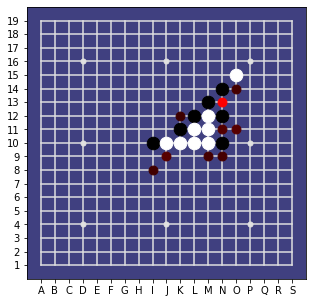

In [20]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(learned, disp_width=5)

## Compare new policy with the MCTS evaluations

### All gameplay

In [28]:
ds = curriculum[ALL_GAMEPLAY]['dataset']
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]
from aegomoku.utils import analyse_example
model = tf.keras.models.load_model(MODEL_DIR / "2_c1.model/")

Next to play: WHITE
Value from WHITE's point of view: 0.21148940920829773
Next to play: WHITE
Value from WHITE's point of view: 0.20794367790222168


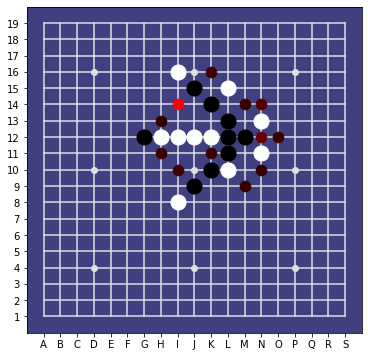

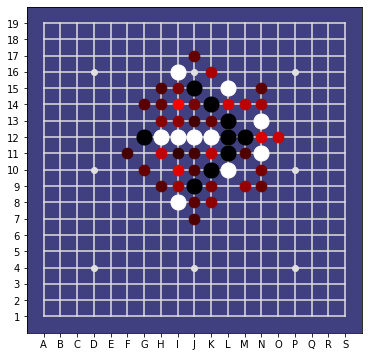

In [58]:
n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=6)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(np.squeeze(p_learned)), np.squeeze(v_learned))
analyse_example(learned, disp_width=6)

In [ ]:
MODEL_DIR = Path(Path.home()) / DATA_DIR / 'models'
course = curriculum[ALL_GAMEPLAY]['dataset']
a_batch = next(iter(course))
batch_size = a_batch[0].shape[0]
from aegomoku.utils import analyse_example
model = tf.keras.models.load_model(MODEL_DIR / "1_c3.model/")

In [ ]:
trainer = Trainer(model)
trainer.train(course, epochs_per_train=30, report_every=1, v_weight=1.0)

In [ ]:
model.save(MODEL_DIR / "1_c3.model")

In [ ]:
n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=7)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(np.squeeze(p_learned)), np.squeeze(v_learned))
analyse_example(learned, disp_width=7)

In [ ]:
ds = curriculum[TERMINAL_OPPORTUNITY]['dataset']
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]
from aegomoku.utils import analyse_example
model = tf.keras.models.load_model("models/1_c1.model/")

In [ ]:
import random
n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(learned, disp_width=5)

## 1.  Refinement: Overcome the killing inhibition

Focus on terminal opportunities: Very little error is acceptable for these conditions

In [ ]:
new_model = tf.keras.models.load_model("models/1_c1.model/")

In [ ]:
trainer = Trainer(new_model)

In [ ]:
ds = curriculum[TERMINAL_OPPORTUNITY]['dataset']
trainer.train(ds, epochs_per_train=5, report_every=1, v_weight=1.0)

In [ ]:
new_model.save('models/1_c2.model')

In [ ]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=5)

# Learned
p_learned, v_learned = new_model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(learned, disp_width=5)

In [ ]:
model.save('models/from_endgame.model')

## All game play
This will last for a couple of hours

Next to play: WHITE
Value from WHITE's point of view: -0.009132922627031803


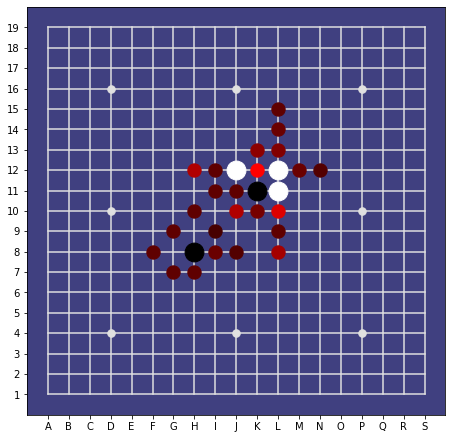

In [32]:
ds = curriculum[ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(example, disp_width=7.5, policy_cutoff=.001)

In [1]:
trainer.train(ds, epochs_per_train=10, report_every=1, v_weight=1.0)

NameError: name 'trainer' is not defined

In [34]:
MODEL_DIR = Path(Path.home()) / DATA_DIR / 'models'
MODEL_DIR

PosixPath('/home/wgiersche/workspace/Project-Ellie/DATA/models')

In [35]:
model.save('models/1_c3.model')

INFO:tensorflow:Assets written to: models/1_c3.model/assets


INFO:tensorflow:Assets written to: models/1_c3.model/assets


In [36]:
model.save(MODEL_DIR / "1_c3.model")

INFO:tensorflow:Assets written to: /home/wgiersche/workspace/Project-Ellie/DATA/models/1_c3.model/assets


INFO:tensorflow:Assets written to: /home/wgiersche/workspace/Project-Ellie/DATA/models/1_c3.model/assets


In [ ]:
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]

In [ ]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(learned, disp_width=5)

## Compare new policy with the MCTS evaluations

### All gameplay

In [10]:
ds = curriculum[ALL_GAMEPLAY]['dataset']
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]
from aegomoku.utils import analyse_example
model = tf.keras.models.load_model(MODEL_DIR / "1_c2.model/")

Next to play: WHITE
Value from WHITE's point of view: 0.03204929456114769
Next to play: WHITE
Value from WHITE's point of view: 0.02725856378674507


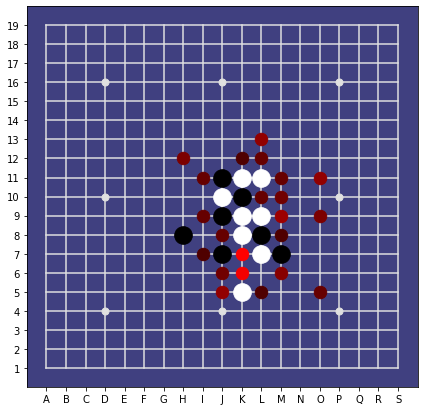

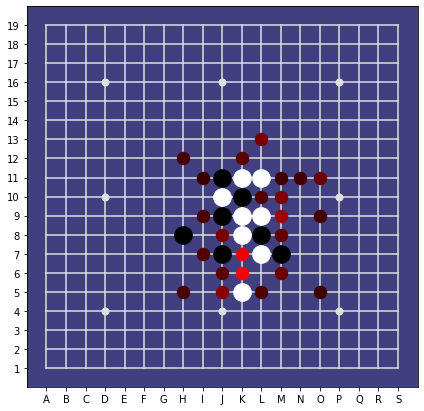

In [78]:
n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=7)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(np.squeeze(p_learned)), np.squeeze(v_learned))
analyse_example(learned, disp_width=7)

In [12]:
MODEL_DIR = Path(Path.home()) / DATA_DIR / 'models'
course = curriculum[ALL_GAMEPLAY]['dataset']
a_batch = next(iter(course))
batch_size = a_batch[0].shape[0]
from aegomoku.utils import analyse_example
model = tf.keras.models.load_model(MODEL_DIR / "1_c3.model/")

In [13]:
trainer = Trainer(model)
trainer.train(course, epochs_per_train=30, report_every=1, v_weight=1.0)

Epoch: 1, Training: p: 3.269748, v: 0.05710475 - elapsed: 499.83s
Epoch: 2, Training: p: 3.263266, v: 0.0570232 - elapsed: 241.0s
Epoch: 3, Training: p: 3.257832, v: 0.05696969 - elapsed: 241.01s
Epoch: 4, Training: p: 3.252664, v: 0.0568921 - elapsed: 241.07s
Epoch: 5, Training: p: 3.247736, v: 0.05681519 - elapsed: 241.1s
Epoch: 6, Training: p: 3.242904, v: 0.05670428 - elapsed: 241.02s
Epoch: 7, Training: p: 3.237946, v: 0.05641698 - elapsed: 240.96s
Epoch: 8, Training: p: 3.232622, v: 0.05561138 - elapsed: 241.18s
Epoch: 9, Training: p: 3.227287, v: 0.05445559 - elapsed: 241.09s
Epoch: 10, Training: p: 3.222123, v: 0.05314413 - elapsed: 241.05s
Epoch: 11, Training: p: 3.217229, v: 0.05176539 - elapsed: 241.07s
Epoch: 12, Training: p: 3.212628, v: 0.0503701 - elapsed: 241.0s
Epoch: 13, Training: p: 3.208241, v: 0.04893593 - elapsed: 241.01s
Epoch: 14, Training: p: 3.204144, v: 0.04751226 - elapsed: 241.05s
Epoch: 15, Training: p: 3.200222, v: 0.04613452 - elapsed: 241.15s


KeyboardInterrupt: 

In [14]:
model.save(MODEL_DIR / "1_c3.model")

INFO:tensorflow:Assets written to: /home/wgiersche/workspace/Project-Ellie/DATA/models/1_c3.model/assets


INFO:tensorflow:Assets written to: /home/wgiersche/workspace/Project-Ellie/DATA/models/1_c3.model/assets


Next to play: WHITE
Value from WHITE's point of view: 1.0
Next to play: WHITE
Value from WHITE's point of view: 0.9887570738792419


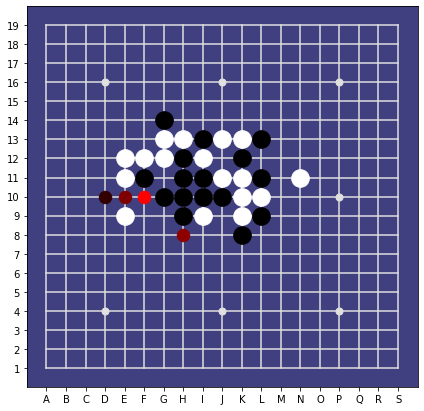

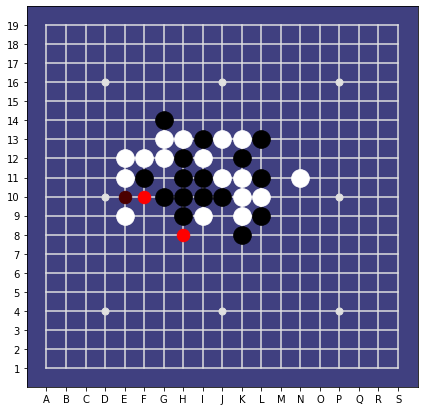

In [90]:
n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=7)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(np.squeeze(p_learned)), np.squeeze(v_learned))
analyse_example(learned, disp_width=7)

In [6]:
ds = curriculum[TERMINAL_OPPORTUNITY]['dataset']
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]
from aegomoku.utils import analyse_example
model = tf.keras.models.load_model("models/1_c1.model/")

Next to play: WHITE
Value from WHITE's point of view: 1.0
Next to play: WHITE
Value from WHITE's point of view: 0.9992259740829468


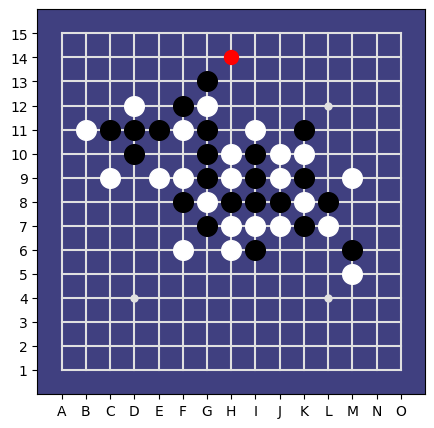

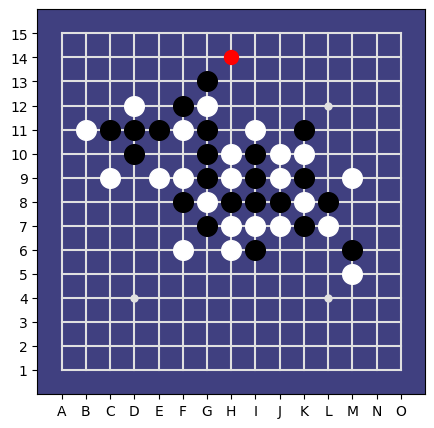

In [33]:
import random
n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(learned, disp_width=5)

## 1.  Refinement: Overcome the killing inhibition

Focus on terminal opportunities: Very little error is acceptable for these conditions

In [63]:
new_model = tf.keras.models.load_model("models/1_c1.model/")

In [64]:
trainer = Trainer(new_model)

In [65]:
ds = curriculum[TERMINAL_OPPORTUNITY]['dataset']
trainer.train(ds, epochs_per_train=5, report_every=1, v_weight=1.0)

Epoch: 1, Training: p: 0.1323763, v: 0.00726073 - elapsed: 4.78s
Epoch: 2, Training: p: 0.1164276, v: 0.004840488 - elapsed: 1.0614s
Epoch: 3, Training: p: 0.1021271, v: 0.003630379 - elapsed: 1.0383s
Epoch: 4, Training: p: 0.09029301, v: 0.002904308 - elapsed: 1.048s
Epoch: 5, Training: (0.090293005, 0.002904308)


In [66]:
new_model.save('models/1_c2.model')

INFO:tensorflow:Assets written to: models/1_c2.model/assets


INFO:tensorflow:Assets written to: models/1_c2.model/assets


In [1]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example((s, p, v), disp_width=5)

# Learned
p_learned, v_learned = new_model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(learned, disp_width=5)

NameError: name 'random' is not defined